In [2]:
# Basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Preprocessing library
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model library
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model saving
import joblib

# Others
import warnings
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('raw data/train.csv')

display(df.head())
print(f'Rows : {df.shape[0]} x Cols : {df.shape[1]}')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.84,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.00,_,809.98,26.82,22 Years and 1 Months,No,49.57,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.00,Good,809.98,31.94,NaN,No,49.57,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.00,Good,809.98,28.61,22 Years and 3 Months,No,49.57,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.00,Good,809.98,31.38,22 Years and 4 Months,No,49.57,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.84,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.00,Good,809.98,24.80,22 Years and 5 Months,No,49.57,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Rows : 100000 x Cols : 28


In [1]:
df.info()

NameError: name 'df' is not defined

In [4]:
df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

# Cleaning

## 1) Useless Column Dropping

In [5]:
df = df.drop(columns = ['ID', 'Month', 'Name', 'SSN', 'Monthly_Inhand_Salary', 'Type_of_Loan'])

## 2) Numerical Fixing

In [6]:
int_cols = ['Age', 'Num_of_Loan', 'Num_of_Delayed_Payment']
float_cols = ['Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

def numerical_cleaning(data):
    if pd.isna(data) or type(data) is not str:
        return data

    cleaned_data = re.sub(r'[^0-9.-]', '', data) # "__ -4_" --> "-4"

    bad_values = {'', 'nan', '!@9#%8', '#F%$D@*&8'}
    
    if cleaned_data == '':
        return np.nan
    else:
        return cleaned_data

In [7]:
cols_to_clean = int_cols + float_cols

for col_name in cols_to_clean:
    df[col_name] = df[col_name].apply(numerical_cleaning)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  object 
 8   Delay_from_due_date       100000 non-null  int64  
 9   Num_of_Delayed_Payment    92998 non-null   object 
 10  Changed_Credit_Limit      97909 non-null   object 
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  ob

In [9]:
df.isnull().sum()

Customer_ID                    0
Age                            0
Occupation                     0
Annual_Income                  0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Delay_from_due_date            0
Num_of_Delayed_Payment      7002
Changed_Credit_Limit        2091
Num_Credit_Inquiries        1965
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age          9030
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     4479
Payment_Behaviour              0
Monthly_Balance             1200
Credit_Score                   0
dtype: int64

In [10]:
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [11]:
df[cols_to_clean].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      100000 non-null  int64  
 1   Num_of_Loan              100000 non-null  int64  
 2   Num_of_Delayed_Payment   92998 non-null   float64
 3   Annual_Income            100000 non-null  float64
 4   Changed_Credit_Limit     97909 non-null   float64
 5   Outstanding_Debt         100000 non-null  float64
 6   Amount_invested_monthly  95521 non-null   float64
 7   Monthly_Balance          98800 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 6.1 MB


In [12]:
def convert_age_to_months(age_str):
    if pd.isna(age_str):
        return np.nan

    parts = age_str.split() # ['22', 'Years', 'and', '10', 'Months']
    years = int(parts[0])
    months = int(parts[3])
    return (years * 12) + months

In [13]:
df['Credit_History_Age_in_Months'] = df['Credit_History_Age'].apply(convert_age_to_months)
df['Credit_History_Age_in_Months'] = df['Credit_History_Age_in_Months'].fillna(0)

df = df.drop(columns = ['Credit_History_Age'])

In [14]:
df['Credit_Score'] = df['Credit_Score'].map({'Poor': 0,
                                             'Standard': 1,
                                             'Good': 2})

df['Credit_Score'].value_counts()

Credit_Score
1    53174
0    28998
2    17828
Name: count, dtype: int64

### -- Before Cleaning --

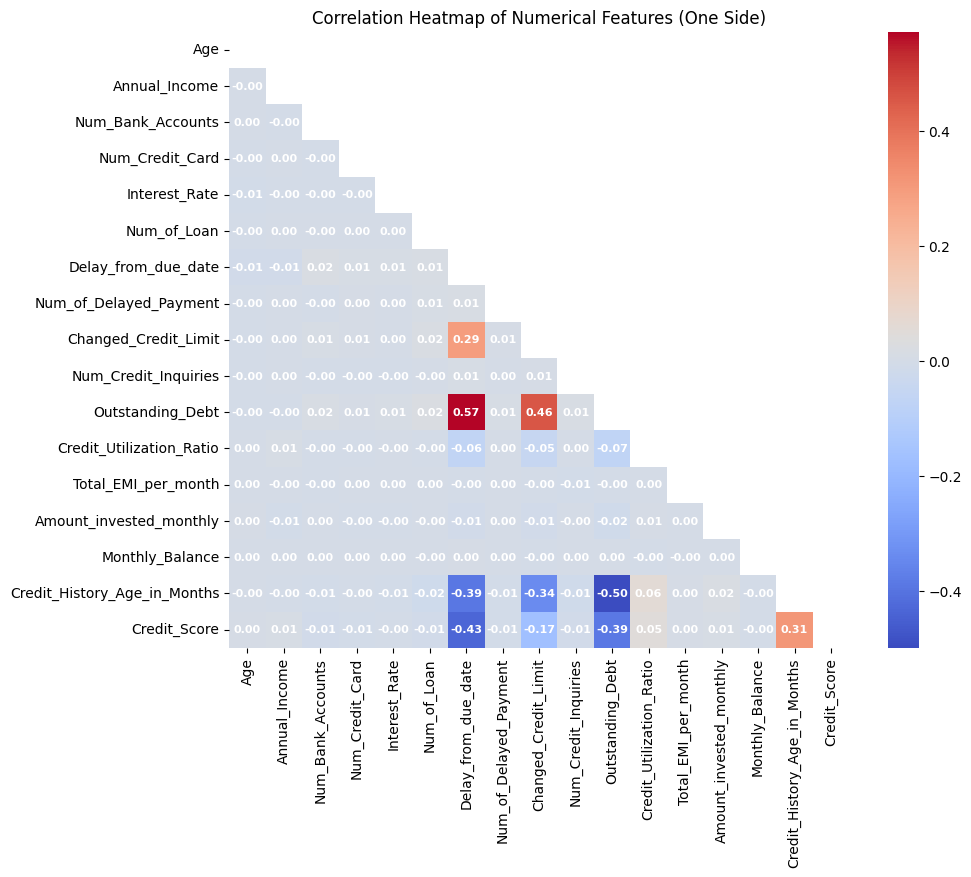

In [15]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Credit_Score']

numeric_train = df[numeric_cols + ['Credit_Score']]
corr = numeric_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True,
            cmap='coolwarm', fmt='.2f',
            annot_kws={'size': 8, 'weight':'bold', 'color':'white'})
plt.title('Correlation Heatmap of Numerical Features (One Side)')
plt.show()

## 3) Anomaly Value Fixing (Realistic)

### 3.1) Age (Change by Median ± 1)

In [16]:
df.groupby('Customer_ID')['Age'].value_counts().head(15)

Customer_ID  Age 
CUS_0x1000   17      5
             18      3
CUS_0x1009   26      6
             25      2
CUS_0x100b   18      4
             19      4
CUS_0x1011   44      7
             43      1
CUS_0x1013   44      6
             43      2
CUS_0x1015   27      7
             4510    1
CUS_0x1018   15      8
CUS_0x1026   51      4
             52      4
Name: count, dtype: int64

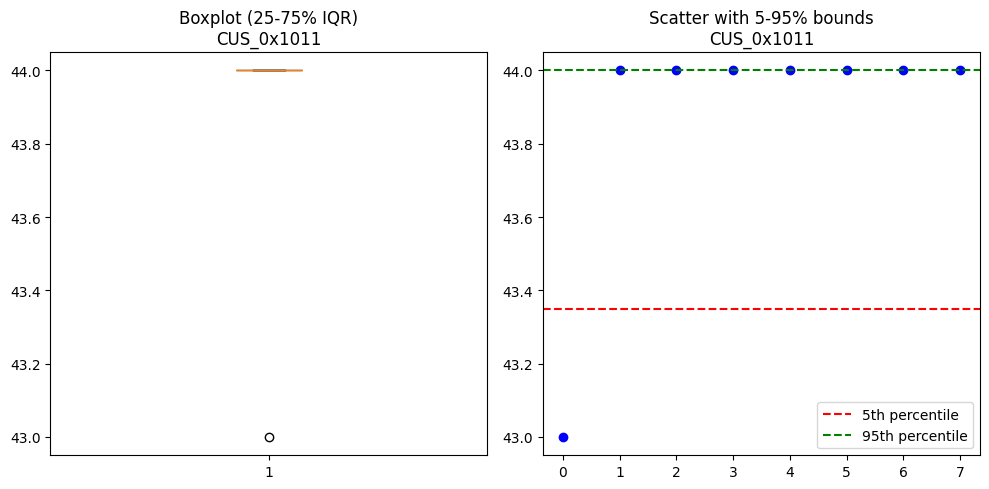

In [17]:
cust = "CUS_0x1011"
data = df[df["Customer_ID"] == cust]["Age"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].boxplot(data, vert=True, patch_artist=True)
axes[0].set_title(f"Boxplot (25-75% IQR)\n{cust}")

q05, q95 = data.quantile([0.05, 0.95])
axes[1].scatter(range(len(data)), data, color="blue")
axes[1].axhline(q05, color="red", linestyle="--", label="5th percentile")
axes[1].axhline(q95, color="green", linestyle="--", label="95th percentile")
axes[1].legend()
axes[1].set_title(f"Scatter with 5-95% bounds\n{cust}")

plt.tight_layout()
plt.show()

Can't change by 25-75& percentile or 5-95% Percentile, we must change it manually by median threshold

In [18]:
col = 'Age'

def replace_outliers_force(g):
    median = g[col].median()
    g[col] = g[col].mask((g[col] > median + 1) | (g[col] < median - 1), np.nan)
    g[col] = g[col].fillna(median)
    return g

df = df.groupby("Customer_ID", group_keys=False).apply(replace_outliers_force)

### 3.2) Other Numerical (Suppose to be Consistant Across All)

All of these methods below are applied here instead of splitting first is because most of the data is based on the same customer that we have, so if they are the same customer but they filled in some inconsistent value, it will be treated as Data Fixing (instead of Data Preprocessing). So overall, this method is alright to be done before the Splitting and WILL NOT cause Data leakage

In [19]:
cols = ["Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", 
        "Num_of_Loan", "Num_Credit_Inquiries"]

def replace_outliers_median(g):
    for col in cols:
        median = g[col].median()
        g[col] = g[col].mask(g[col] != median, np.nan)
        g[col] = g[col].fillna(median)
    return g

df = df.groupby("Customer_ID", group_keys=False).apply(replace_outliers_median)

### 3.3) Other Numerical (Same CustomerID must have similar Value by Previous Value)

In [20]:
cols = [
    "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Outstanding_Debt", 
    "Credit_History_Age_in_Months", "Delay_from_due_date"]
def replace_outliers_with_ffill_bfill(g):
    for col in cols:
        Q1, Q3 = g[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

        g[col] = g[col].mask((g[col] < lower) | (g[col] > upper), np.nan)

        g[col] = g[col].ffill().bfill()

    return g

df = df.groupby("Customer_ID", group_keys=False).apply(replace_outliers_with_ffill_bfill)

### 3.4) Other Numerical (Same CustomerID must have similar Value by median)

In [21]:
cols = [
    "Amount_invested_monthly", "Monthly_Balance",
    "Annual_Income", "Total_EMI_per_month"]

def replace_outliers_with_median(g):
    for col in cols:
        Q1, Q3 = g[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        g[col] = g[col].mask((g[col] < lower) | (g[col] > upper), np.nan)

        median_val = g[col].median()
        g[col] = g[col].fillna(median_val)

    return g

df = df.groupby("Customer_ID", group_keys=False).apply(replace_outliers_with_median)

### 3.5) Categorical Cols (Suppose to be Consistant Across All)

In [22]:
display(df['Payment_Behaviour'].unique())
df["Payment_Behaviour"] = df["Payment_Behaviour"].replace("!@9#%8", np.nan)

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments'], dtype=object)

In [23]:
display(df['Occupation'].unique())
df["Occupation"] = df["Occupation"].replace("_______", np.nan)

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [24]:
display(df['Credit_Mix'].unique())
df["Credit_Mix"] = df["Credit_Mix"].replace("_", np.nan)

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

In [25]:
display(df['Payment_of_Min_Amount'].unique())
df["Payment_of_Min_Amount"] = df["Payment_of_Min_Amount"].replace("NM", np.nan)

array(['No', 'NM', 'Yes'], dtype=object)

In [26]:
cat_cols = [
    "Payment_Behaviour", "Occupation",
    "Credit_Mix", "Payment_of_Min_Amount"]

def fill_mode(g):
    for col in cat_cols:
        if g[col].isna().any():
            mode_val = g[col].mode()
            if not mode_val.empty:
                g[col] = g[col].fillna(mode_val[0])
    return g

df = df.groupby("Customer_ID", group_keys=False).apply(fill_mode)

In [27]:
df[cat_cols].isnull().sum()

Payment_Behaviour        0
Occupation               0
Credit_Mix               0
Payment_of_Min_Amount    0
dtype: int64

In [28]:
df

,Customer_ID,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_in_Months
0,CUS_0xd40,23.00,Scientist,19114.12,3.00,4.00,3.00,4.00,3.00,7.00,11.27,4.00,Good,809.98,26.82,No,49.57,80.42,High_spent_Small_value_payments,312.49,2,265.00
1,CUS_0xd40,23.00,Scientist,19114.12,3.00,4.00,3.00,4.00,3.00,7.00,11.27,4.00,Good,809.98,31.94,No,49.57,118.28,Low_spent_Large_value_payments,284.63,2,265.00
2,CUS_0xd40,23.00,Scientist,19114.12,3.00,4.00,3.00,4.00,3.00,7.00,11.27,4.00,Good,809.98,28.61,No,49.57,81.70,Low_spent_Medium_value_payments,331.21,2,267.00
3,CUS_0xd40,23.00,Scientist,19114.12,3.00,4.00,3.00,4.00,5.00,4.00,11.27,4.00,Good,809.98,31.38,No,49.57,199.46,Low_spent_Small_value_payments,223.45,2,268.00
4,CUS_0xd40,23.00,Scientist,19114.12,3.00,4.00,3.00,4.00,6.00,4.00,11.27,4.00,Good,809.98,24.80,No,49.57,41.42,High_spent_Medium_value_payments,341.49,2,269.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CUS_0x942c,25.00,Mechanic,39628.99,4.00,6.00,7.00,2.00,23.00,7.00,11.50,3.00,Good,502.38,34.66,No,35.10,60.97,High_spent_Large_value_payments,479.87,0,378.00
99996,CUS_0x942c,25.00,Mechanic,39628.99,4.00,6.00,7.00,2.00,18.00,7.00,11.50,3.00,Good,502.38,40.57,No,35.10,54.19,High_spent_Medium_value_payments,496.65,0,379.00
99997,CUS_0x942c,25.00,Mechanic,39628.99,4.00,6.00,7.00,2.00,27.00,6.00,11.50,3.00,Good,502.38,41.26,No,35.10,24.03,High_spent_Large_value_payments,516.81,0,380.00
99998,CUS_0x942c,25.00,Mechanic,39628.99,4.00,6.00,7.00,2.00,20.00,6.00,11.50,3.00,Good,502.38,33.64,No,35.10,251.67,Low_spent_Large_value_payments,319.16,1,381.00


# EDA

In [29]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Credit_Score']
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.00,33.31,10.76,14.00,24.00,33.00,42.00,56.00
Annual_Income,100000.00,51456.07,134587.84,7005.93,19342.97,37002.58,71689.68,21936192.00
Num_Bank_Accounts,100000.00,5.37,2.59,-1.00,3.00,5.00,7.00,10.50
Num_Credit_Card,100000.00,5.53,2.07,0.50,4.00,5.00,7.00,11.00
Interest_Rate,100000.00,14.53,8.74,1.00,7.00,13.00,20.00,34.00
Num_of_Loan,100000.00,3.53,2.45,0.00,2.00,3.00,5.00,9.00
Delay_from_due_date,100000.00,21.07,14.79,-5.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,100000.00,13.62,31.18,-3.00,9.00,14.00,18.00,4281.00
Changed_Credit_Limit,100000.00,10.40,6.54,-5.93,5.49,9.37,14.68,35.40
Num_Credit_Inquiries,100000.00,5.79,3.83,0.00,3.00,5.00,8.50,17.00


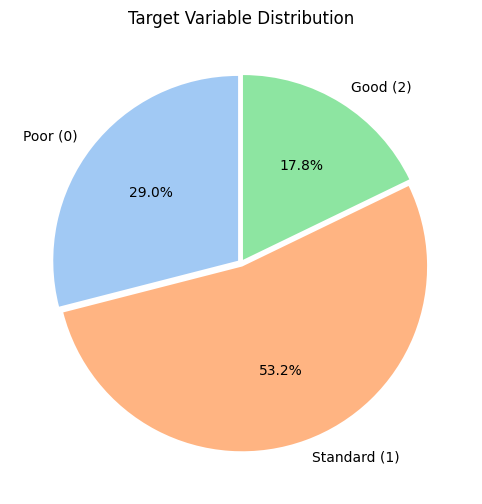

In [31]:
data = df['Credit_Score'].value_counts().sort_index()
labels = ['Poor (0)', 'Standard (1)', 'Good (2)']

colors = sns.color_palette('pastel', len(labels))

plt.figure(figsize=(8,6))
plt.pie(data, labels=labels, autopct='%1.1f%%',
        explode=[0.02] * len(labels),
        startangle=90,
        colors=colors)
plt.title('Target Variable Distribution')
plt.show()


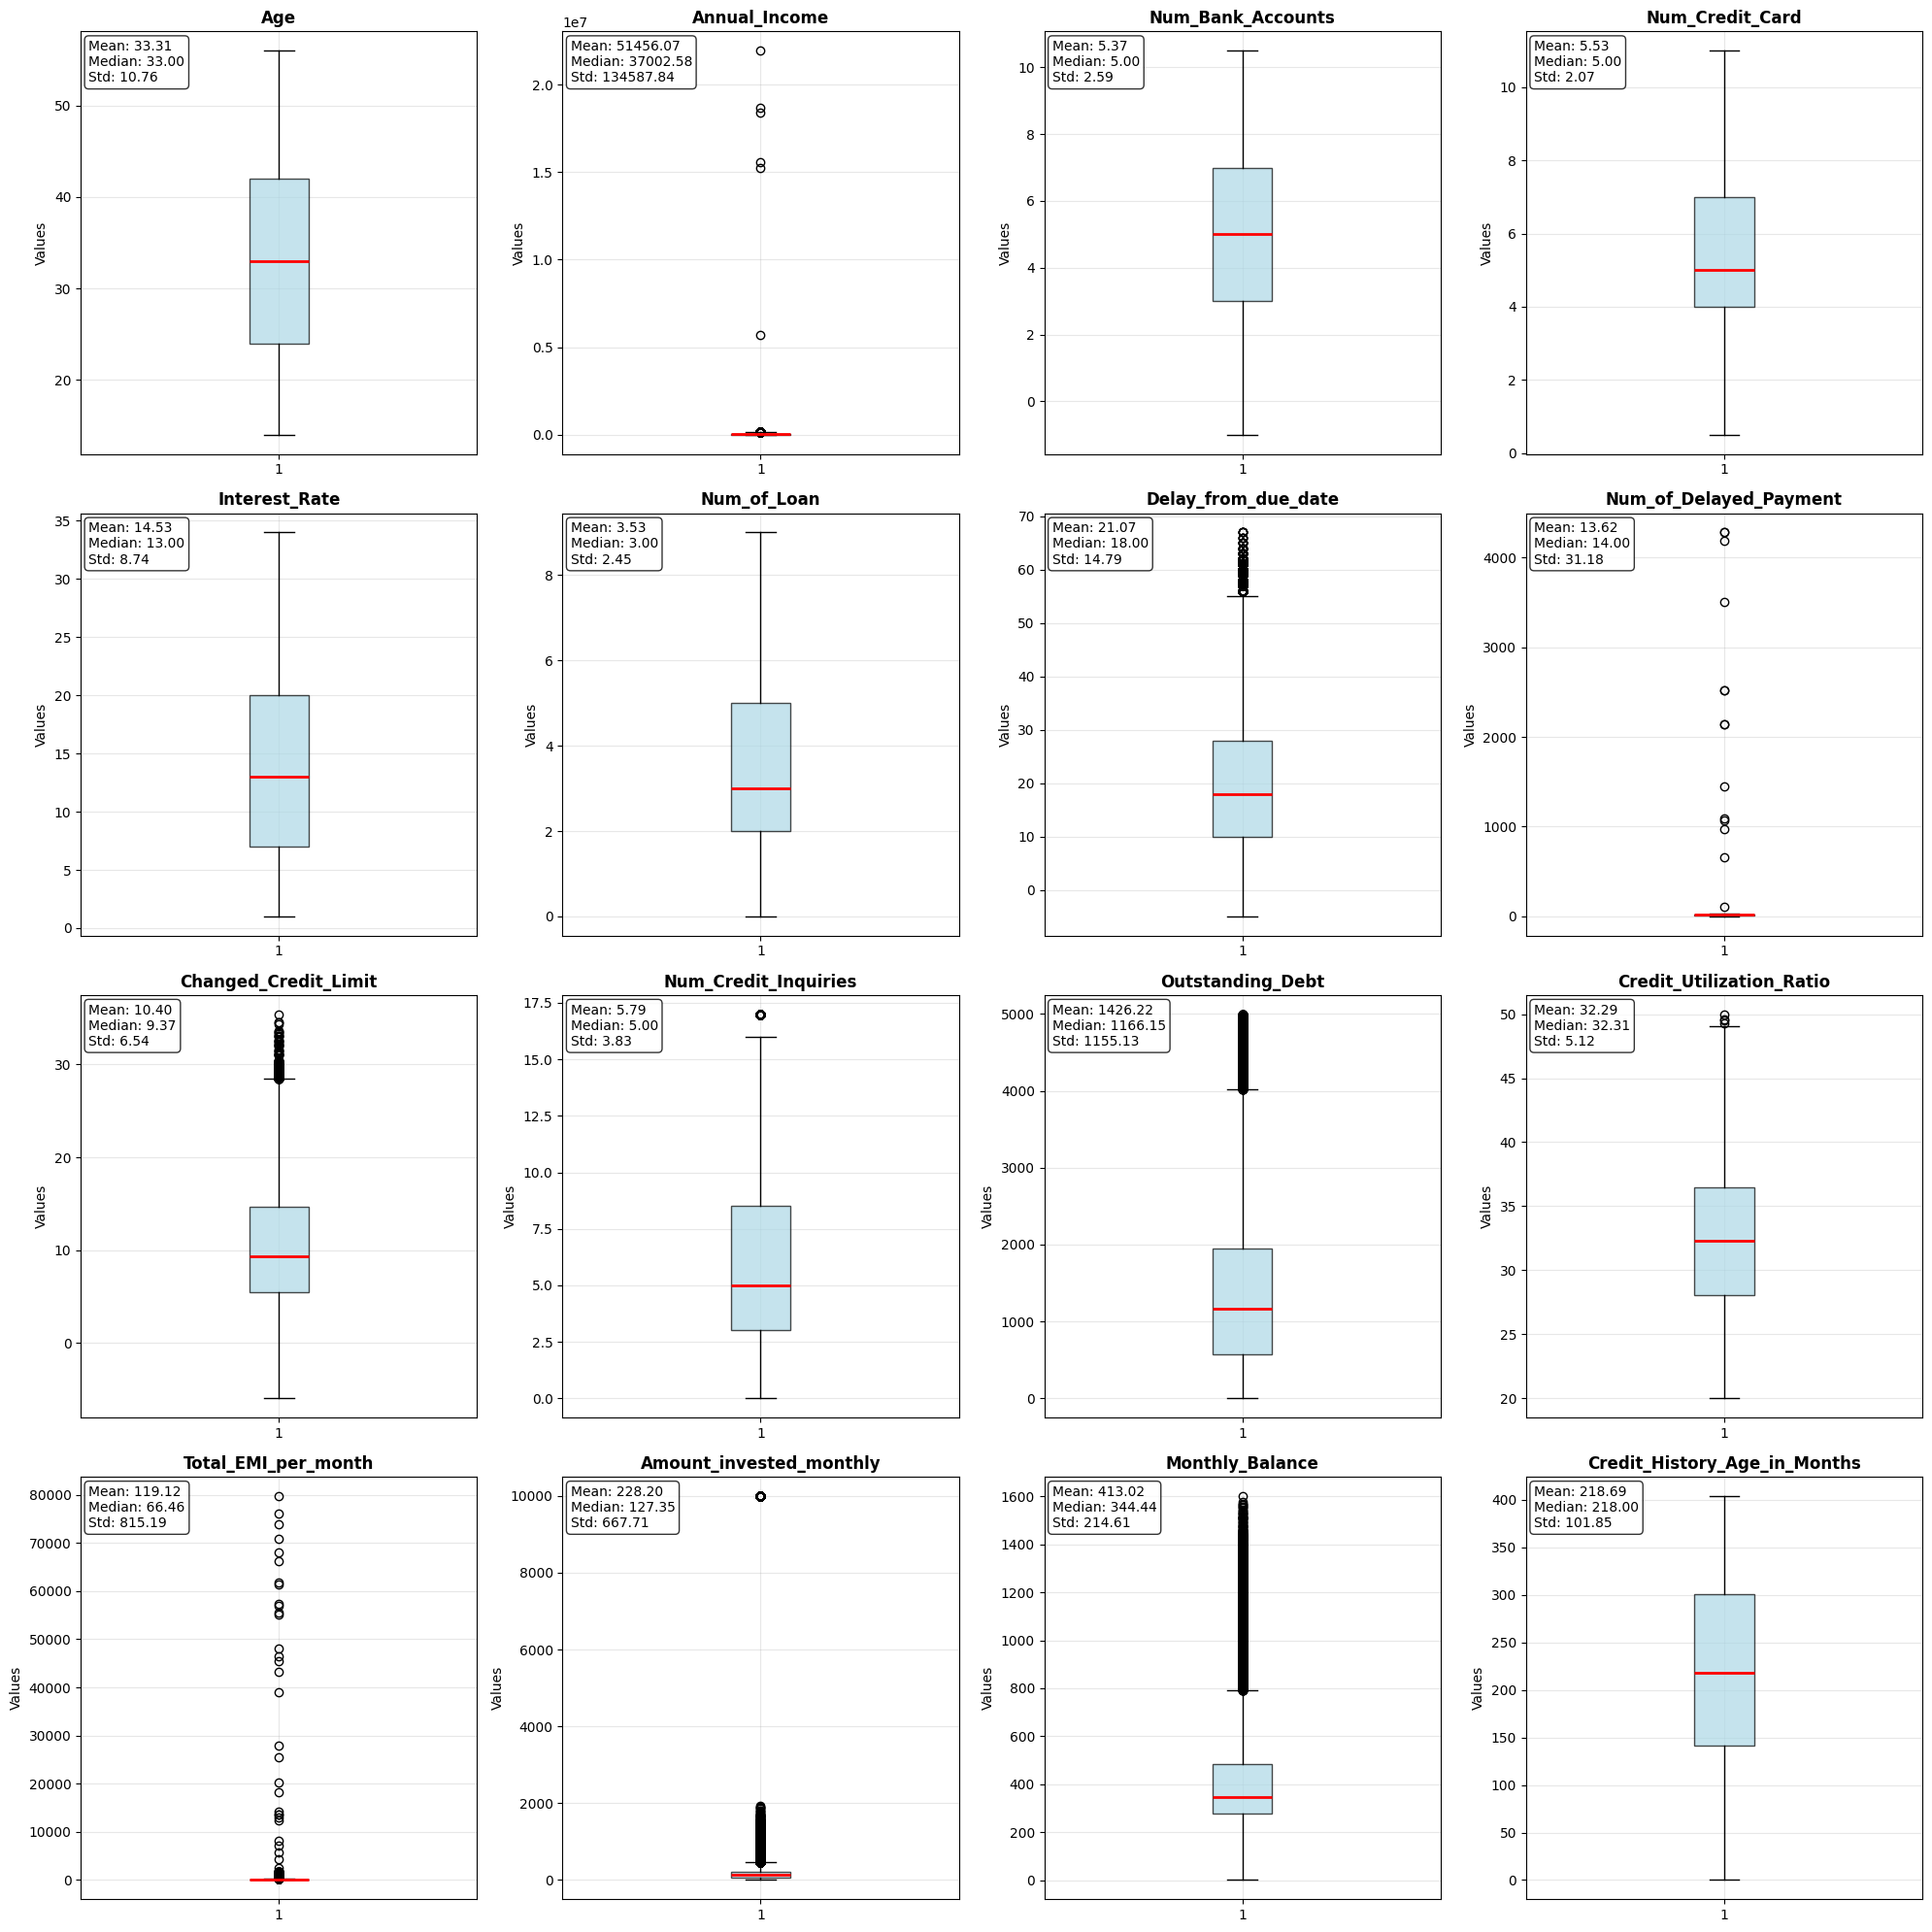

In [32]:
n_numeric = len(numeric_cols)
n_cols = 4
n_rows = math.ceil(n_numeric / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        ax = axes[i]
        bp = ax.boxplot(df[col].dropna(), patch_artist=True, 
                       boxprops=dict(facecolor='lightblue', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2))
        
        ax.set_title(f'{col}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Values')
        ax.grid(True, alpha=0.3)
        
        stats_text = f'Mean: {df[col].mean():.2f}\nMedian: {df[col].median():.2f}\nStd: {df[col].std():.2f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide empty subplots
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

--> Mayoritas outlier dengan proporsi yang tidak wajar, seperti Age yang mencapai maximum 8000+, Annual income yang sangat tidak wajar, dan lainnya

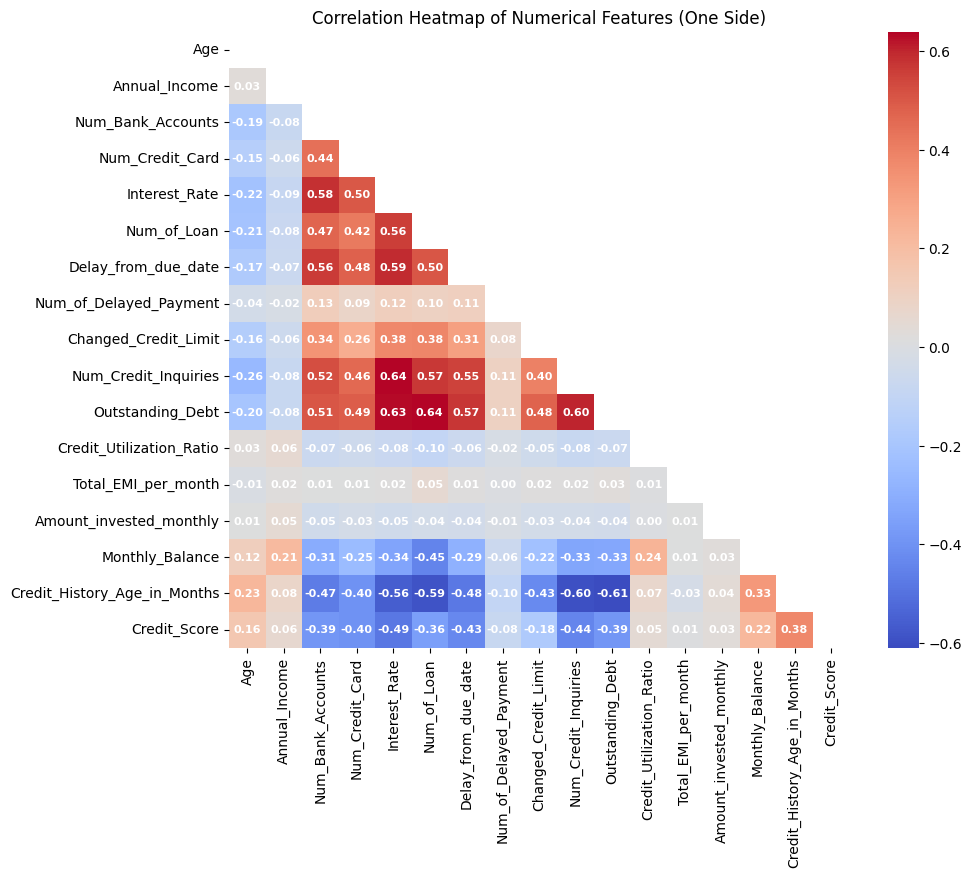

In [33]:
import numpy as np

numeric_train = df[numeric_cols + ['Credit_Score']]
corr = numeric_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True,
            cmap='coolwarm', fmt='.2f',
            annot_kws={'size': 8, 'weight':'bold', 'color':'white'})
plt.title('Correlation Heatmap of Numerical Features (One Side)')
plt.show()

# Deep Cleaning

In [34]:
df.isnull().sum()

Customer_ID                     0
Age                             0
Occupation                      0
Annual_Income                   0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Delay_from_due_date             0
Num_of_Delayed_Payment          0
Changed_Credit_Limit            0
Num_Credit_Inquiries            0
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly         0
Payment_Behaviour               0
Monthly_Balance                 0
Credit_Score                    0
Credit_History_Age_in_Months    0
dtype: int64

## 1) Data Splitting

In [35]:
X = df.drop(['Credit_Score', 'Customer_ID'], axis = 1)
y = df['Credit_Score']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Train-set Dimension: ', X_train.shape)
print('Test-set Dimension: ', X_test.shape)

Train-set Dimension:  (80000, 20)
Test-set Dimension:  (20000, 20)


## 2) Cap Value (Realistic)

In [37]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,80000.00,33.33,10.76,14.00,24.00,33.00,42.00,56.00
Annual_Income,80000.00,51714.51,147904.73,7005.93,19417.83,37182.62,71756.20,21936192.00
Num_Bank_Accounts,80000.00,5.36,2.59,-1.00,3.00,5.00,7.00,10.50
Num_Credit_Card,80000.00,5.53,2.07,0.50,4.00,5.00,7.00,11.00
Interest_Rate,80000.00,14.50,8.75,1.00,7.00,13.00,20.00,34.00
Num_of_Loan,80000.00,3.53,2.44,0.00,2.00,3.00,5.00,9.00
Delay_from_due_date,80000.00,21.04,14.77,-5.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,80000.00,13.62,31.02,-3.00,9.00,14.00,18.00,4281.00
Changed_Credit_Limit,80000.00,10.38,6.53,-5.93,5.49,9.36,14.64,35.40
Num_Credit_Inquiries,80000.00,5.79,3.83,0.00,3.00,5.00,8.50,17.00


In [38]:
cols_to_cap_0 = [
    'Num_Bank_Accounts', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit'
]

cap_values = {}
for col in cols_to_cap_0:
    lower = 0
    upper = X_train[col].quantile(1.00)
    cap_values[col] = (lower, upper)

for col, (low, up) in cap_values.items():
    X_train[col] = X_train[col].clip(lower=low, upper=up)
    X_test[col] = X_test[col].clip(lower=low, upper=up)

Capping is done after the Splitting to preserve real world data demonstration

In [39]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,80000.00,33.33,10.76,14.00,24.00,33.00,42.00,56.00
Annual_Income,80000.00,51714.51,147904.73,7005.93,19417.83,37182.62,71756.20,21936192.00
Num_Bank_Accounts,80000.00,5.37,2.59,0.00,3.00,5.00,7.00,10.50
Num_Credit_Card,80000.00,5.53,2.07,0.50,4.00,5.00,7.00,11.00
Interest_Rate,80000.00,14.50,8.75,1.00,7.00,13.00,20.00,34.00
Num_of_Loan,80000.00,3.53,2.44,0.00,2.00,3.00,5.00,9.00
Delay_from_due_date,80000.00,21.05,14.77,0.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,80000.00,13.62,31.02,0.00,9.00,14.00,18.00,4281.00
Changed_Credit_Limit,80000.00,10.39,6.52,0.00,5.49,9.36,14.64,35.40
Num_Credit_Inquiries,80000.00,5.79,3.83,0.00,3.00,5.00,8.50,17.00


## 4) Null Value Imputation

In [40]:
df.isnull().sum()

Customer_ID                     0
Age                             0
Occupation                      0
Annual_Income                   0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Delay_from_due_date             0
Num_of_Delayed_Payment          0
Changed_Credit_Limit            0
Num_Credit_Inquiries            0
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly         0
Payment_Behaviour               0
Monthly_Balance                 0
Credit_Score                    0
Credit_History_Age_in_Months    0
dtype: int64

In [41]:
cols_with_na_num = [

]

cols_with_na_cat = [

]

for col in cols_with_na_num:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

for col in cols_with_na_cat:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col] = X_test[col].fillna(mode_val)

print("Train missing:", X_train[cols_with_na_num + cols_with_na_cat].isnull().any().any())
print("Test missing:", X_test[cols_with_na_num + cols_with_na_cat].isnull().any().any())

Train missing: False
Test missing: False


In [42]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,80000.00,33.33,10.76,14.00,24.00,33.00,42.00,56.00
Annual_Income,80000.00,51714.51,147904.73,7005.93,19417.83,37182.62,71756.20,21936192.00
Num_Bank_Accounts,80000.00,5.37,2.59,0.00,3.00,5.00,7.00,10.50
Num_Credit_Card,80000.00,5.53,2.07,0.50,4.00,5.00,7.00,11.00
Interest_Rate,80000.00,14.50,8.75,1.00,7.00,13.00,20.00,34.00
Num_of_Loan,80000.00,3.53,2.44,0.00,2.00,3.00,5.00,9.00
Delay_from_due_date,80000.00,21.05,14.77,0.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,80000.00,13.62,31.02,0.00,9.00,14.00,18.00,4281.00
Changed_Credit_Limit,80000.00,10.39,6.52,0.00,5.49,9.36,14.64,35.40
Num_Credit_Inquiries,80000.00,5.79,3.83,0.00,3.00,5.00,8.50,17.00


# Data Preprocessing

## 1) Outlier Grouping

In [43]:
numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Credit_Score']
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [44]:
outlier = []
no_outlier = []
def outlier_detection(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].tolist()

    if outliers:
        print(f"⚠️ Outliers | '{col}'.")
        outlier.append(col)
    else:
        print(f"✅ No outliers | '{col}'.")
        no_outlier.append(col)

In [45]:
for col in numeric_cols:
    outlier_detection(X_train, col)

✅ No outliers | 'Age'.
⚠️ Outliers | 'Annual_Income'.
✅ No outliers | 'Num_Bank_Accounts'.
✅ No outliers | 'Num_Credit_Card'.
✅ No outliers | 'Interest_Rate'.
✅ No outliers | 'Num_of_Loan'.
⚠️ Outliers | 'Delay_from_due_date'.
⚠️ Outliers | 'Num_of_Delayed_Payment'.
⚠️ Outliers | 'Changed_Credit_Limit'.
⚠️ Outliers | 'Num_Credit_Inquiries'.
⚠️ Outliers | 'Outstanding_Debt'.
⚠️ Outliers | 'Credit_Utilization_Ratio'.
⚠️ Outliers | 'Total_EMI_per_month'.
⚠️ Outliers | 'Amount_invested_monthly'.
⚠️ Outliers | 'Monthly_Balance'.
✅ No outliers | 'Credit_History_Age_in_Months'.


## 2) Categorical Cols Grouping

In [46]:
for col in categorical_cols:
    print(f"Column: {col}")
    print(X_train[col].unique())
    print("-" * 50)

Column: Occupation
['Journalist' 'Accountant' 'Scientist' 'Manager' 'Media_Manager'
 'Musician' 'Entrepreneur' 'Writer' 'Architect' 'Mechanic' 'Doctor'
 'Teacher' 'Lawyer' 'Developer' 'Engineer']
--------------------------------------------------
Column: Credit_Mix
['Good' 'Standard' 'Bad']
--------------------------------------------------
Column: Payment_of_Min_Amount
['No' 'Yes']
--------------------------------------------------
Column: Payment_Behaviour
['High_spent_Medium_value_payments' 'High_spent_Large_value_payments'
 'Low_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'High_spent_Small_value_payments' 'Low_spent_Medium_value_payments']
--------------------------------------------------


In [47]:
ordinal_mappings = [
    ['Bad', 'Standard', 'Good'], # Credit_Mix
    ['No', 'Yes'], # Payment_of_Min_Amount
    ['Low_spent_Small_value_payments', 'Low_spent_Medium_value_payments',
     'Low_spent_Large_value_payments', 'High_spent_Small_value_payments',
     'High_spent_Medium_value_payments', 'High_spent_Large_value_payments'] # Payment_Behaviour
]

In [48]:
ordinal_cols = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
ohe_cols = [i for i in categorical_cols if i not in ordinal_cols]
scaler_cols = no_outlier
robust_cols = outlier

transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scaler_cols),
        ('robust', RobustScaler(), robust_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
        ('ordinal', OrdinalEncoder(categories=ordinal_mappings), ordinal_cols)
    ]
)

# Fit and transform
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [49]:
ohe_feature_names = transformer.named_transformers_['ohe'].get_feature_names_out(ohe_cols)
all_feature_names = scaler_cols + robust_cols + list(ohe_feature_names) + ordinal_cols

X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

X_train_df.head()

,Age,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Credit_History_Age_in_Months,Annual_Income,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Occupation_Accountant,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour
0,-1.24,-1.68,-1.22,-1.43,-0.62,0.77,1.23,-0.22,-0.89,-0.59,-0.18,-0.07,1.23,0.56,-0.09,2.47,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,4.00
1,-0.77,-0.14,-2.19,-0.51,0.19,1.26,1.45,-0.22,-0.44,-0.34,-0.91,-0.32,0.92,2.43,0.25,1.66,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,5.00
2,1.46,-0.14,0.71,-0.74,-0.22,1.00,-0.17,0.61,-0.67,-0.82,-0.18,-0.51,-1.03,1.71,-0.11,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
3,0.06,0.63,0.71,-0.63,0.19,1.25,-0.28,-0.11,-0.11,0.21,-0.36,-0.72,-0.62,-0.07,-0.15,-0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,2.00
4,-0.50,-1.30,-1.22,-0.63,-1.03,0.71,-0.31,-0.89,-0.33,0.06,-0.73,-0.31,-0.72,-0.43,-0.39,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,0.00,4.00


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_transformed, y_train)

y_pred = rf_clf.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      5874
           1       0.83      0.82      0.83     10599
           2       0.79      0.76      0.78      3527

    accuracy                           0.82     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
[[4949  923    2]
 [1198 8678  723]
 [   4  832 2691]]


# Dataset Saving

In [51]:
feature_names = transformer.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

print("Shape :", X_train_transformed_df.shape)
print("Target distribution :\n", y_train.value_counts())

Shape : (80000, 34)
Target distribution :
 Credit_Score
1    42575
0    23124
2    14301
Name: count, dtype: int64


## 1) Original

In [52]:
train_original_df = pd.concat([X_train_transformed_df, y_train.reset_index(drop=True)], axis=1)
train_original_df.to_csv('clean data/train_transformed_original.csv', index=False)

In [53]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
test_transformed_df = pd.concat([X_test_transformed_df, y_test.reset_index(drop=True)], axis=1)
test_transformed_df.to_csv('clean data/test_transformed.csv', index=False)

## 2) Upsampling

In [54]:
smote = SMOTE(random_state=42)

X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train_transformed_df, y_train)

train_upsampled_df = pd.concat([X_train_upsampled, y_train_upsampled], axis=1)
train_upsampled_df.to_csv('clean data/train_transformed_upsampled.csv', index=False)

## 3) Undersampling

In [55]:
rus = RandomUnderSampler(random_state=42)

X_train_downsampled, y_train_downsampled = rus.fit_resample(X_train_transformed_df, y_train)

train_downsampled_df = pd.concat([X_train_downsampled, y_train_downsampled], axis=1)
train_downsampled_df.to_csv('clean data/train_transformed_downsampled.csv', index=False)